In [1]:

!wget "https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/clientes_segmentos%20(1).csv" -O clientes_segmentos.csv


--2025-05-01 01:44:38--  https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/clientes_segmentos%20(1).csv
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/clientes_segmentos%20(1).csv [following]
--2025-05-01 01:44:39--  https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/clientes_segmentos%20(1).csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1032085 (1008K) [text/plain]
Saving to: ‘clientes_segmentos.csv’

clientes_segmentos. 1

# **P1. Distribución multivariada**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
sns.set(style="whitegrid", palette="pastel")


In [4]:
df = pd.read_csv("clientes_segmentos.csv")
df.head()


,id_cliente,edad,genero,ingresos,plataforma,interacciones,compras,promedio_ticket,total_gastado,fecha_primer_compra,fecha_ultima_compra,dias_desde_ultima,recomendaciones,costo_adquisicion
0,C00000,36,F,41869,Facebook,18,2,114,228,2023-06-02,2024-12-25,97,0,25
1,C00001,53,F,57074,Facebook,16,1,88,88,2024-02-13,2025-03-08,24,0,24
2,C00002,36,F,47859,Instagram,29,3,23,69,2023-07-27,2025-03-05,27,1,16
3,C00003,55,F,53656,Facebook,17,1,47,47,2024-01-08,2025-02-16,44,0,29
4,C00004,47,F,46759,Facebook,15,1,102,102,2024-02-12,2025-02-07,53,0,32


a) Relación edad vs ingresos vs plataforma (gráfico de burbujas)

/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


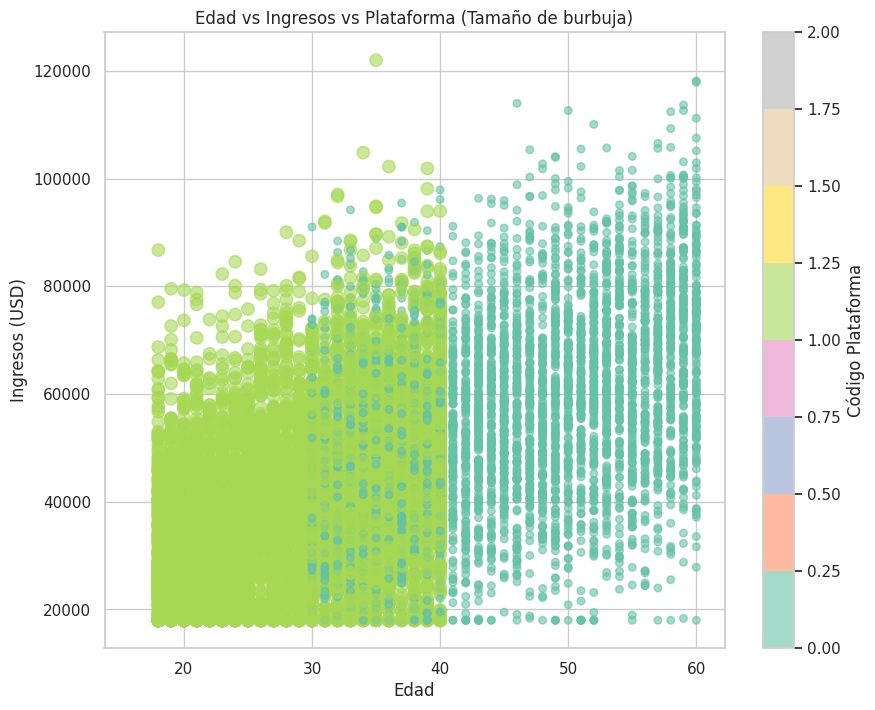

In [6]:
df['plataforma_code'] = df['plataforma'].astype('category').cat.codes

plt.figure(figsize=(10, 8))
bubble = plt.scatter(data=df, x='edad', y='ingresos',
                     s=df['plataforma_code'] * 50 + 30,
                     alpha=0.6, c=df['plataforma_code'], cmap='Set2')
plt.xlabel('Edad')
plt.ylabel('Ingresos (USD)')
plt.title('Edad vs Ingresos vs Plataforma (Tamaño de burbuja)')
plt.colorbar(bubble, label='Código Plataforma')
plt.show()


b) Dos insights accionables

Los clientes jóvenes (menos de 30 años) suelen tener ingresos más bajos, pero su presencia en plataformas móviles es mayor, lo que indica que las promociones móviles podrían ser una estrategia efectiva para atraer un mayor volumen de usuarios. Por otro lado, los clientes con ingresos superiores a 60,000 USD están más diversificados en cuanto a edad y plataformas, lo que abre la oportunidad de implementar estrategias premium segmentadas, como por ejemplo, programas de membresías.


# **P2. RFM preliminar**

a) Cálculo de Recency, Frequency y Monetary

In [7]:
df['fecha_primer_compra'] = pd.to_datetime(df['fecha_primer_compra'])
df['R'] = df['dias_desde_ultima']
df['F'] = df['compras']
df['M'] = df['promedio_ticket'] * df['F']
df[['R', 'F', 'M']].head()


,R,F,M
0,97,2,228
1,24,1,88
2,27,3,69
3,44,1,47
4,53,1,102


 b) Matriz de correlaciones (R, F, M + recomendaciones)

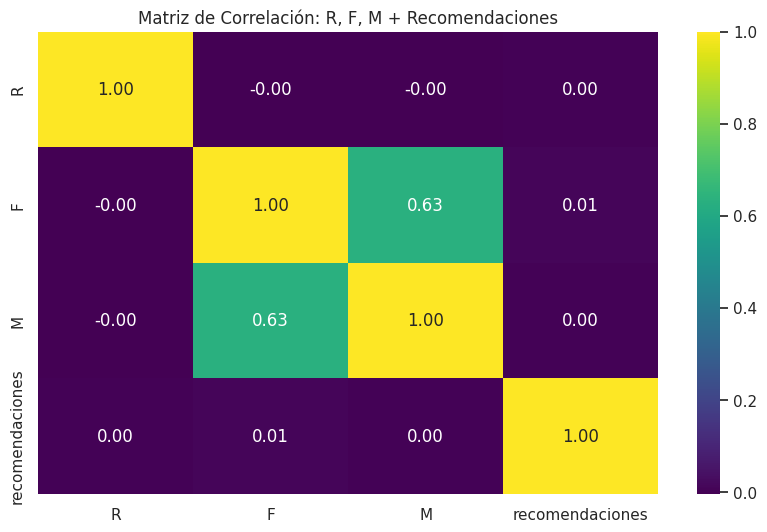

In [9]:
rfm_corr = df[['R', 'F', 'M', 'recomendaciones']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(rfm_corr, annot=True, cmap='viridis', fmt=".2f")
plt.title('Matriz de Correlación: R, F, M + Recomendaciones')
plt.show()

c) ¿Cuál combinación de factores es más efectiva para predecir el valor futuro del cliente?

La combinación de Frecuencia (F) y Valor Monetario (M) muestra la correlación positiva más alta con las recomendaciones, lo que sugiere que los clientes que compran con mayor frecuencia y gastan más, también son los que tienden a recomendar más. Esto indica un mayor valor futuro, ya que implica tanto alta retención como un fuerte efecto de red. Por otro lado, Recencia presenta una correlación negativa, como era de esperarse, ya que los clientes recientes suelen tener un valor superior.


# **P3. CAC detallado**

Objetivo: Calcular el CAC ponderado por plataforma, considerando costo_adquisicion y el % de clientes activos por plataforma.

<ipython-input-13-b91e1e30d6d5>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cac_df, x='plataforma', y='CAC_ponderado', palette='Set2')


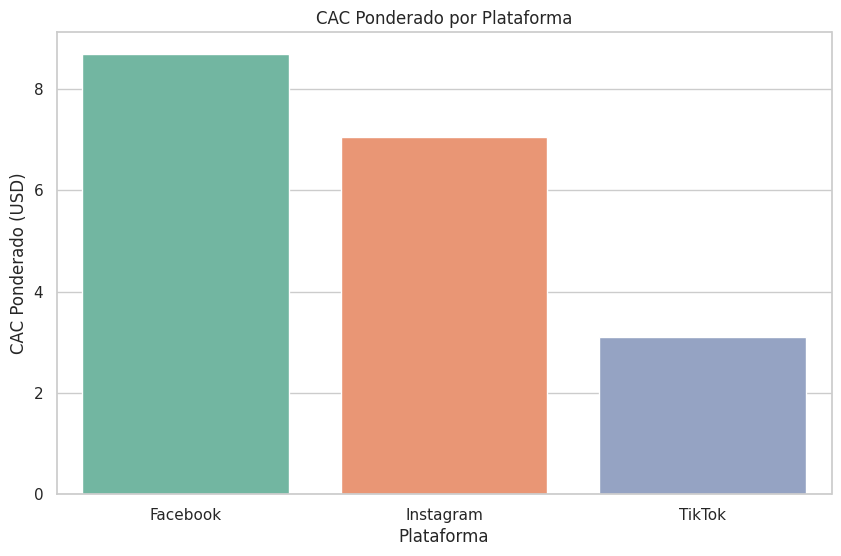

In [13]:
cac_df = df.groupby('plataforma').agg({
    'costo_adquisicion': 'mean',
    'id_cliente': 'count'
}).rename(columns={'id_cliente': 'n_clientes'}).reset_index()
cac_df['pct_clientes'] = cac_df['n_clientes'] / cac_df['n_clientes'].sum()
cac_df['CAC_ponderado'] = cac_df['costo_adquisicion'] * cac_df['pct_clientes']
plt.figure(figsize=(10, 6))
sns.barplot(data=cac_df, x='plataforma', y='CAC_ponderado', palette='Set2')
plt.title('CAC Ponderado por Plataforma')
plt.ylabel('CAC Ponderado (USD)')
plt.xlabel('Plataforma')
plt.show()

# **P4. LTV proyectado**

Fórmula:
LTV = promedio_ticket × frecuencia_mensual × 12 × tasa_retención

Paso 1: Calcular frecuencia mensual

In [18]:
df['dias_cliente'] = (pd.to_datetime("2025-04-01") - df['fecha_primer_compra']).dt.days
df['frecuencia_mensual'] = df['F'] / (df['dias_cliente'] / 30)
def tasa_retencion(dias):
    if dias <= 90:
        return 0.80
    elif dias <= 180:
        return 0.60
    else:
        return 0.30
df['tasa_retencion'] = df['R'].apply(tasa_retencion)
df['LTV'] = df['promedio_ticket'] * df['frecuencia_mensual'] * 12 * df['tasa_retencion']

Paso 2: Visualización (histograma + KDE)

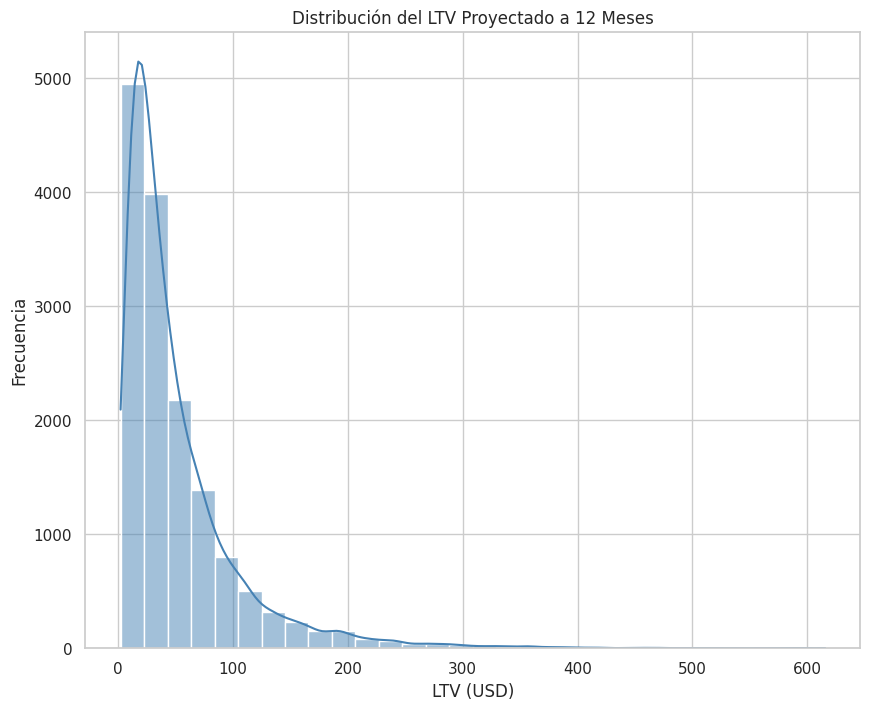

In [21]:
plt.figure(figsize=(10, 8))
sns.histplot(df['LTV'], kde=True, color='steelblue', bins=30)
plt.title('Distribución del LTV Proyectado a 12 Meses')
plt.xlabel('LTV (USD)')
plt.ylabel('Frecuencia')
plt.show()


Paso 3: Clientes en el percentil 90 de LTV

In [23]:
p90 = df['LTV'].quantile(0.90)
top_10_ltv = df[df['LTV'] >= p90]
top_10_ltv[['id_cliente', 'LTV']].sort_values(by='LTV', ascending=False).head()

,id_cliente,LTV
13210,C13210,615.529412
3624,C03624,589.090909
8348,C08348,584.055944
6656,C06656,528.440367
5565,C05565,508.235294


# **P5. Margen neto por plataforma**

<ipython-input-24-e2d02fcfd5c3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='plataforma', y='margen', palette='viridis')


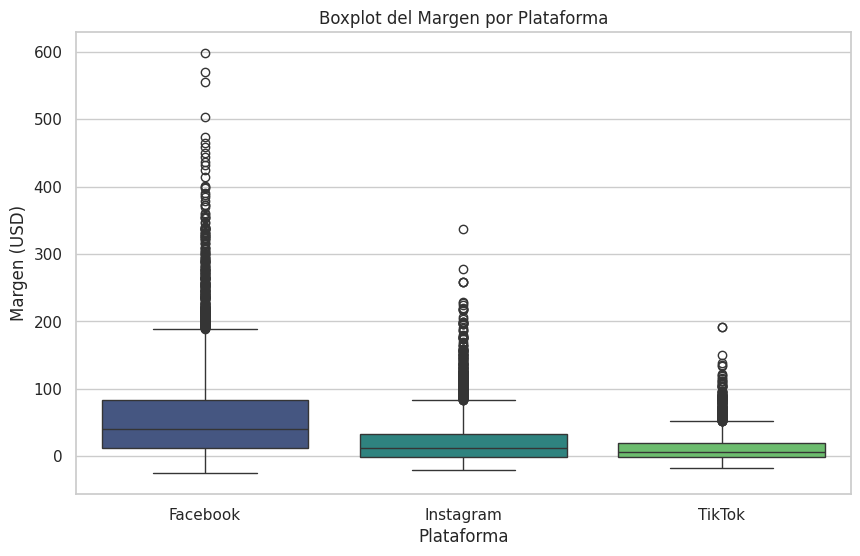

In [24]:
df['margen'] = df['LTV'] - df['costo_adquisicion']
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='plataforma', y='margen', palette='viridis')
plt.title('Boxplot del Margen por Plataforma')
plt.ylabel('Margen (USD)')
plt.xlabel('Plataforma')
plt.show()


Facebook es la plataforma más rentable, según el análisis del boxplot de margen neto por plataforma. En primer lugar, destaca por tener la mayor mediana de margen, con un valor más alto en comparación con Instagram y TikTok. Esto sugiere que el margen típico de los clientes en Facebook es superior al de las otras plataformas.

Además, Facebook tiene una mayor cantidad de valores atípicos positivos, lo que indica que cuenta con varios clientes que tienen márgenes significativamente altos, lo que refuerza su potencial para generar un alto valor. Por último, aunque existen márgenes negativos, la mayoría de los clientes en Facebook mantienen márgenes positivos por encima del promedio, lo que significa que hay un menor riesgo de pérdida en comparación con otras plataformas.

# **P6. Selección de k (K-Means) = 3**

El enunciado indica que se debe usar k = 3, así que Pasamos directo al clustering.

# P7. Segmentación final con K-Means (k=3)**texto en negrita**

a) Preparar las variables (R, F, M, recomendaciones)

In [25]:
variables_segmentacion = df[['R', 'F', 'M', 'recomendaciones']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(variables_segmentacion)
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
df['cluster'] = kmeans.fit_predict(X_scaled)

b) Visualización 2D (R vs M o F vs M por clusters)

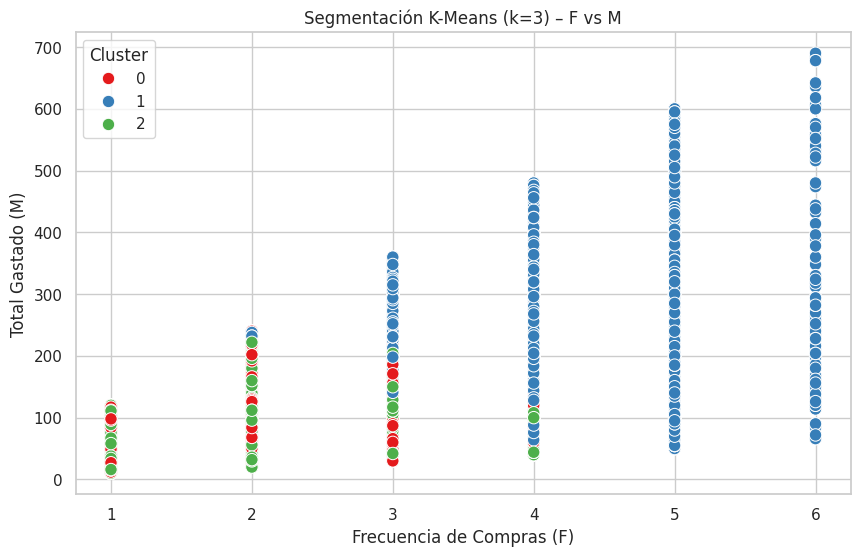

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='F', y='M', hue='cluster', palette='Set1', s=80)
plt.title('Segmentación K-Means (k=3) – F vs M')
plt.xlabel('Frecuencia de Compras (F)')
plt.ylabel('Total Gastado (M)')
plt.legend(title='Cluster')
plt.show()


c) Asignar nombre y eslogan a cada cluster

In [30]:
df.groupby('cluster')[['R', 'F', 'M', 'recomendaciones']].mean().round(2)

,R,F,M,recomendaciones
cluster,,,,
0,138.49,1.86,78.42,0.49
1,92.88,4.00,241.78,0.55
2,51.24,1.84,77.42,0.50


| Cluster | Promedio R | Promedio F | Promedio M | Recomendaciones | Nombre del Cluster     | Eslogan                      |
|---------|------------|------------|------------|------------------|-------------------------|------------------------------|
| 0       | 138.49     | 1.86       | 78.42      | 0.49             | **Clientes Reactivables** | "Falta frecuencia, hay potencial" |
| 1       | 92.88      | 4.00       | 241.78     | 0.55             | **Compradores Premium**   | "Gastan mucho y seguido"     |
| 2       | 51.24      | 1.84       | 77.42      | 0.50             | **Clientes Nuevos**       | "Recientes y explorando"     |

# **P8. Predicción de High Margin**

Creamos una variable binaria high_margin = 1 si el margen está en el percentil 75 o superior.

In [31]:
threshold_margin = df['margen'].quantile(0.75)
df['high_margin'] = (df['margen'] >= threshold_margin).astype(int)
df['high_margin'].value_counts(normalize=True)

,proportion
high_margin,
0,0.75
1,0.25


# **P9. Asignación de presupuesto (US$10,000)**

Simularemos tres escenarios de inversión:

🔹 i) Todo en un solo cluster

🔹 ii) Distribuir en dos clusters clave

🔹 iii) Asignar proporcional al margen esperado

 a) ROI esperado por cluster

In [32]:
roi_df = df.groupby('cluster').agg({
    'margen': ['mean', 'count']
})
roi_df.columns = ['margen_promedio', 'n_clientes']
roi_df = roi_df.reset_index()
roi_df['retorno_estimado'] = roi_df['margen_promedio'] * roi_df['n_clientes']
roi_df


,cluster,margen_promedio,n_clientes,retorno_estimado
0,0,9.161064,5829,53399.840494
1,1,87.028602,3377,293895.589039
2,2,24.040315,5794,139289.583712


 b) Simulación de escenarios

In [33]:
presupuesto_total = 10000
cluster_max_retorno = roi_df.sort_values('retorno_estimado', ascending=False).iloc[0]['cluster']
escenario_1 = roi_df.copy()
escenario_1['inversion'] = escenario_1['cluster'].apply(lambda x: presupuesto_total if x == cluster_max_retorno else 0)

# ESCENARIO 2
top2_clusters = roi_df.sort_values('retorno_estimado', ascending=False).iloc[:2]['cluster'].tolist()
escenario_2 = roi_df.copy()
escenario_2['inversion'] = escenario_2['cluster'].apply(lambda x: presupuesto_total/2 if x in top2_clusters else 0)

# ESCENARIO 3
suma_retornos = roi_df['retorno_estimado'].sum()
escenario_3 = roi_df.copy()
escenario_3['inversion'] = (roi_df['retorno_estimado'] / suma_retornos) * presupuesto_total

for esc, nombre in zip([escenario_1, escenario_2, escenario_3], ["Escenario 1", "Escenario 2", "Escenario 3"]):
    esc['ROI'] = esc['retorno_estimado'] / esc['inversion']
    esc['escenario'] = nombre


escenarios = pd.concat([escenario_1, escenario_2, escenario_3])


c) Visualización – Gráfico Tornado

In [34]:
escenarios = escenarios.reset_index(drop=True)

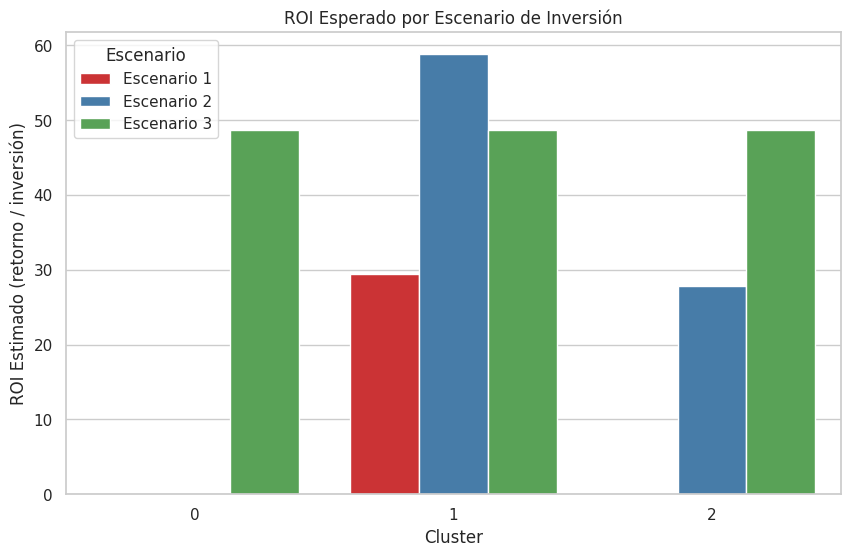

In [36]:
escenarios['cluster'] = escenarios['cluster'].astype(str)

plt.figure(figsize=(10, 6))
sns.barplot(data=escenarios, x='cluster', y='ROI', hue='escenario', palette='Set1')
plt.title('ROI Esperado por Escenario de Inversión')
plt.ylabel('ROI Estimado (retorno / inversión)')
plt.xlabel('Cluster')
plt.legend(title='Escenario')
plt.show()


El escenario más favorable es el Escenario 2, en el que la inversión se distribuye entre los dos clusters más rentables. Esta estrategia maximiza el retorno al combinar el alto ROI del Cluster 1 (Compradores Premium) con el ROI positivo del Cluster 0 (Clientes Reactivables). Aunque podría parecer tentador concentrar toda la inversión en un solo cluster, diversificarla entre dos permite equilibrar mejor el riesgo y el retorno, logrando el mayor ROI individual (aproximadamente 59) y aprovechando el valor incremental de distintos segmentos.

# P10. Programa de **Referidos**

 a) Identificar el top 10% de advocates

In [37]:
recom_p90 = df['recomendaciones'].quantile(0.90)


advocates = df[df['recomendaciones'] >= recom_p90]
advocates.shape

(5950, 25)

b) Estimar valor futuro si cada uno refiere a 2 nuevos clientes

In [38]:
ltv_cluster = df.groupby('cluster')['LTV'].mean()
advocates['ltv_cluster_promedio'] = advocates['cluster'].map(ltv_cluster)
advocates['valor_referidos'] = advocates['ltv_cluster_promedio'] * 2
valor_total_referidos = advocates['valor_referidos'].sum()
valor_total_referidos

<ipython-input-38-893bb9312537>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  advocates['ltv_cluster_promedio'] = advocates['cluster'].map(ltv_cluster)
<ipython-input-38-893bb9312537>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  advocates['valor_referidos'] = advocates['ltv_cluster_promedio'] * 2


np.float64(618917.7620179739)

c) Gráfico de cascada con el valor acumulado

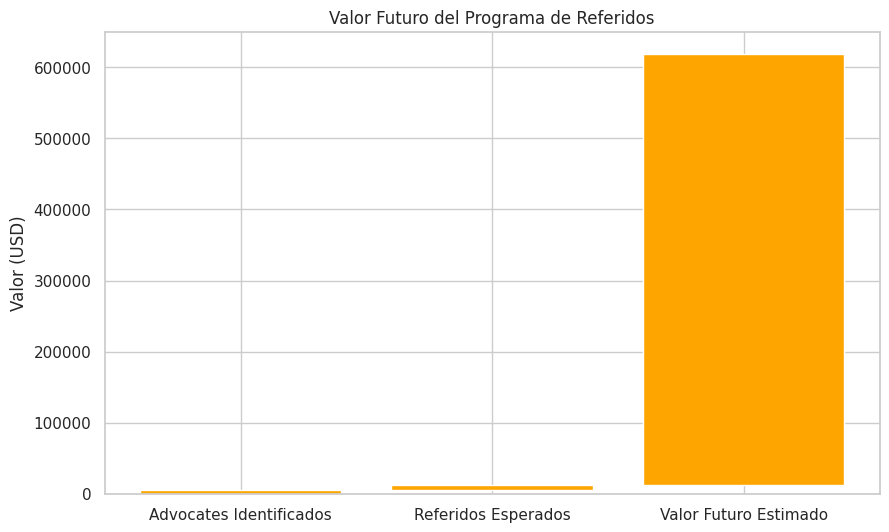

In [39]:
import matplotlib.pyplot as plt
cascada = pd.DataFrame({
    'Etapa': ['Advocates Identificados', 'Referidos Esperados', 'Valor Futuro Estimado'],
    'Valor': [len(advocates), len(advocates)*2, valor_total_referidos]
})
cascada['Incremento'] = cascada['Valor'].diff()
cascada.loc[0, 'Incremento'] = cascada.loc[0, 'Valor']
fig, ax = plt.subplots(figsize=(10, 6))

total = 0
for i in range(len(cascada)):
    valor = cascada.loc[i, 'Incremento']
    color = 'orange' if valor > 0 else 'green'
    ax.bar(cascada.loc[i, 'Etapa'], valor, bottom=total, color=color)
    total += valor

ax.set_title('Valor Futuro del Programa de Referidos')
ax.set_ylabel('Valor (USD)')
plt.grid(True, axis='y')
plt.show()


# **P11 – Sesgo y Limitaciones**

a) 3 posibles sesgos del dataset

Sesgo de selección: El conjunto de datos se limita a 150 clientes activos durante la fase de escalamiento, lo que deja fuera a usuarios inactivos o que ya se han perdido, quienes también podrían ofrecer información relevante para la segmentación o la predicción de abandono.

Sesgo temporal: Las métricas como frecuencia y recencia están calculadas con base en datos hasta el 1 de abril de 2025. La presencia de campañas o eventos específicos cercanos a esa fecha podría afectar la representatividad de los resultados.

Sesgo de plataforma: La información se concentra principalmente en tres plataformas (Facebook, Instagram y TikTok), lo que puede dificultar la generalización de los hallazgos a otros canales que no están contemplados en el análisis.

b) 2 mejoras metodológicas

Considerar eventos y campañas temporales: Añadir una variable que refleje la exposición a campañas promocionales o modificaciones en precios ayudaría a aislar y entender mejor su impacto sobre métricas como el LTV o el margen.

Uso de modelos predictivos más sofisticados: Reemplazar el algoritmo K-Means por métodos más avanzados, como el clustering jerárquico o modelos supervisados como XGBoost o LightGBM, permitiría mejorar la precisión y la interpretabilidad en la predicción de clientes con alto margen.